In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.insert(1, "../python/functions")
sys.path.insert(2, "../python/architecture")

In [3]:
from data_prep_functions import mnist_prep
from model_functions import *
from plotting_functions import *
import no_gpu
import reproducible

In [4]:
X_train, X_val, y_train, y_val = mnist_prep()

In [5]:
# use samller dataset for increased speed
X_train_small = X_train[:1000, :]
X_val_small = X_val[:500, :]
y_train_small = y_train[:1000]
y_val_small = y_val[:500]

n_cols = X_train_small.shape[1]

# EnKF

In [6]:
X_train = X_train_small
X_test = X_val_small
y_train = y_train_small
y_test = y_val_small

In [7]:
batch_size = 50
epochs = 10
particles = 10
early_stopping = False
early_stopping_diff = 0.001
batch_normal = False # evtl. noch einbauen, obwohl im Paper nicht gemacht (aber Achtung mit den Dimensionen unten!!!)
shuffle = True
randomization = True

In [8]:
layers = 5
neurons = [128, 128, 64, 32, 10]
n_cols = X_train.shape[1]

In [9]:
delta = 0.005
h_0 = 2
epsilon = 0.5

In [10]:
n = len(X_train)
num_batches = int(np.ceil(n / batch_size))
batch_indices = np.cumsum([0] + list(np.ones(num_batches) * batch_size))
batch_indices[-1] = n

In [11]:
model_dict = {}
weights_dict = {}
y_pred_dict = {}
jacobian_dict = {}
weights_vector_dict = {}
train_acc_dict = {}
test_acc_dict = {}
iteration_dict = {}
new_weights_dict = {}

# init_model already has weights and biases following the Glorot distribution
# it can already be used to predict and evaluate, but it is very bad (<10% accuracy)
# only used to determine shapes and shape_elements via its weights
init_model = nn_model_structure(layers = layers,
                                neurons = neurons,
                                n_cols = n_cols)
init_model = nn_model_compile(init_model,
                              optimizer = "sgd")
weights = init_model.get_weights()
# shape contains the shapes of the weight matrices and bias vectors as a list of arrays
shapes = [np.array(params.shape) for params in weights]
# shape_elements contains the indices of the weights as a vector and tells where to cut
shape_elements = np.cumsum([0] + [np.prod(shape) for shape in shapes])

In [12]:
for i in range(particles):
    # just an initial model with the correct structure regarding neurons, layers, activation functions, Glorot initialization
    model = nn_model_structure(layers = layers,
                               neurons = neurons,
                               n_cols = n_cols)
    model = nn_model_compile(model,
                             optimizer = "sgd")
    # for every particle write the model in a dictionary
    model_dict["model_{}".format(str(i+1))] = model
    
    # for every particles write the weights and biases in a dictionary
    weights_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                    .get_weights()
    
    train_acc_dict["model_{}".format(str(i+1))] = []
    test_acc_dict["model_{}".format(str(i+1))] = []
    iteration_dict["model_{}".format(str(i+1))] = []

In [13]:
# mean_model as the model with the mean of the weights of all particle models
mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
mean_model = init_model
mean_model.set_weights(mean_weights)

mean_model_train_acc = np.array(mean_model.evaluate(X_train, y_train)[1])
mean_model_test_acc = np.array(mean_model.evaluate(X_test, y_test)[1])

16/16 [==============================] - 0s 976us/step - loss: 2.3035 - accuracy: 0.0900


In [14]:
for i in range(particles):
    print(model_dict["model_{}".format(str(i+1))].evaluate(X_val_small, y_val_small)[1])

16/16 [==============================] - 0s 407us/step - loss: 2.3805 - accuracy: 0.1140
0.11400000005960464
16/16 [==============================] - 0s 974us/step - loss: 2.4470 - accuracy: 0.0700
0.07000000029802322
16/16 [==============================] - 0s 2ms/step - loss: 2.3891 - accuracy: 0.0820
0.0820000022649765
16/16 [==============================] - 0s 1ms/step - loss: 2.4278 - accuracy: 0.1240
0.12399999797344208
16/16 [==============================] - 0s 407us/step - loss: 2.4027 - accuracy: 0.1060
0.10599999874830246
16/16 [==============================] - 0s 976us/step - loss: 2.4314 - accuracy: 0.0720
0.07199999690055847
16/16 [==============================] - 0s 974us/step - loss: 2.3707 - accuracy: 0.0920
0.09200000017881393
16/16 [==============================] - 0s 594us/step - loss: 2.5079 - accuracy: 0.0680
0.06800000369548798
16/16 [==============================] - 0s 973us/step - loss: 2.4219 - accuracy: 0.1140
0.11400000005960464
16/16 [=================

In [15]:
import time
start_time = time.time()

In [16]:
# loop over all epochs
for epoch in range(epochs):
    # shuffle the data
    if shuffle:
        indices = y_train.sample(frac=1).index
        X_batches = [X_train[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [y_train.iloc[indices].reset_index(drop = True)[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]   
    # loop over all batches
    for b in range(num_batches):    
        for i in range(particles):
            # set new weights for model
            model_dict["model_{}".format(str(i+1))].set_weights(weights_dict["model_{}".format(str(i+1))])
            
            # for every particle write the predictions on the training batches in a dictionary
            y_pred_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                            .predict(X_batches[b])

            # for every particle write the Jacobian in a dictionary
            jacobian_dict["model_{}".format(str(i+1))] = (-1) * np.multiply(np.array(y_batches[b]), 
                                                                            np.array(1 / (y_pred_dict["model_{}".format(str(i+1))] + delta)))
            
            # for every particle write the training accuracy of the current iteration in a dictionary
            train_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_train, y_train, verbose = 0)[1])
            
            # for every particle write the test accuracy of the current iteration in a dictionary
            test_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_test, y_test, verbose = 0)[1])
            
            # for every particle write the current iteration in a dictionary
            iteration_dict["model_{}".format(str(i+1))].append("Epoch: {}, Batch: {}.".format(epoch+1, b+1))
            
        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
        
        # compute the matrix D elementwise
        d = np.zeros(shape = (particles, particles))
        for k in range(particles):
            y_pred_centered = y_pred_dict["model_{}".format(str(k+1))] - y_pred_mean
            for j in range(particles):
                d[k][j] = np.sum(np.multiply(y_pred_centered, jacobian_dict["model_{}".format(str(j+1))]))
                                       
        # compute the scalar h_t
        h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
        
        # Reshape the weights and biases so that they are no longer matrices and vectores, but now one single vector
        for i in range(particles):
            weights_array = np.array([])
            for j in range(len(weights_dict["model_{}".format(str(i+1))])):
                weights_array = np.append(weights_array, np.reshape(weights_dict["model_{}".format(str(i+1))][j], (1, -1)).ravel())
            weights_vector_dict["model_{}".format(str(i+1))] = weights_array
          
        # matrix with particle parameters as row vectors
        weights_all_ptcls = np.array(list(weights_vector_dict.values()))

        # compute the matrix with the updates for each particle
        weights_all_ptcls = weights_all_ptcls - h_t * np.matmul(d, weights_all_ptcls)

        for i in range(particles):
            # write the updates back into the dictionary
            new_weights_dict["model_{}".format(str(i+1))] = weights_all_ptcls[i]
            # reshape the updates, so that they are of the original matrx and vector shape
            for l in range(len(shape_elements)-1):
                start = shape_elements[l]
                end = shape_elements[l+1]
                weights_dict["model_{}".format(str(i+1))][l] = np.reshape(new_weights_dict["model_{}".format(str(i+1))][start:end], tuple(shapes[l]))
            if randomization:
                # add randomization/ noise to each particle
                new_weights = []
                # standard deviation for scaled Glorot distribution
                for s in range(len(shapes)):
                    if shapes[s].shape[0] == 2:
                        fan_in = shapes[s][0]
                        fan_out = shapes[s][1]
                    if shapes[s].shape[0] == 1:
                        fan_in = shapes[s-1][0]
                        fan_out = shapes[s][0]
                    stddev = np.sqrt(np.sqrt(h_t)) * np.sqrt(2 / (fan_in + fan_out))
                    noise = np.random.normal(loc = 0.0,
                                             scale = stddev,
                                             size = tuple(shapes[s]))
                    new_weights.append(weights_dict["model_{}".format(str(i+1))][s] + noise)
                weights_dict["model_{}".format(str(i+1))] = new_weights
                
    if randomization:
        # randomize particles around their mean
        weights_mean = list(np.mean(list(weights_dict.values()), axis = 0))
        for i in range(particles):
            new_weights = []
            # standard deviation for Glorot distribution
            for s in range(len(shapes)):
                if shapes[s].shape[0] == 2:
                    fan_in = shapes[s][0]
                    fan_out = shapes[s][1]
                if shapes[s].shape[0] == 1:
                    fan_in = shapes[s-1][0]
                    fan_out = shapes[s][0]
                stddev = np.sqrt(2 / (fan_in + fan_out))
                noise = np.random.normal(loc = 0.0,
                                         scale = stddev,
                                         size = tuple(shapes[s]))
                new_weights.append(weights_mean[s] + noise)
            weights_dict["model_{}".format(str(i+1))] = new_weights
            
    # update the mean_model
    mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
    mean_model.set_weights(mean_weights)
    
    mean_model_train_acc = np.append(mean_model_train_acc, np.array(mean_model.evaluate(X_train, y_train, verbose = 0)[1]))
    mean_model_test_acc = np.append(mean_model_test_acc, np.array(mean_model.evaluate(X_test, y_test, verbose = 0)[1]))
    
    # early stopping
    if early_stopping:
        if epoch == 0:
            test_acc_old = 0
        else:
            test_acc_new = mean_model_test_acc[epoch]
            if np.absolute(test_acc_new - test_acc_old) <= early_stopping_diff:
                print("STOP: Early Stopping after epoch {} because improvement in test accuracy is only {}."\
                                                                     .format(epoch+1, test_acc_new - test_acc_old))
                break
            test_acc_old = test_acc_new

In [17]:
end_time = time.time()
print("Calculation time: {}".format(end_time - start_time))

Calculation time: 317.87491726875305


In [18]:
for i in range(particles):
    print(model_dict["model_{}".format(str(i+1))].evaluate(X_val_small, y_val_small)[1])

16/16 [==============================] - 0s 2ms/step - loss: 12.0287 - accuracy: 0.0900
0.09000000357627869
16/16 [==============================] - 0s 1ms/step - loss: 5.3777 - accuracy: 0.0780
0.07800000160932541
16/16 [==============================] - 0s 2ms/step - loss: 2.5574 - accuracy: 0.0880
0.08799999952316284
16/16 [==============================] - 0s 2ms/step - loss: 503.4715 - accuracy: 0.1040
0.10400000214576721
16/16 [==============================] - 0s 2ms/step - loss: 180.8303 - accuracy: 0.0860
0.0860000029206276
16/16 [==============================] - 0s 2ms/step - loss: 532.5594 - accuracy: 0.1060
0.10599999874830246
16/16 [==============================] - 0s 2ms/step - loss: 168.9409 - accuracy: 0.1040
0.10400000214576721
16/16 [==============================] - 0s 2ms/step - loss: 32.9782 - accuracy: 0.1000
0.10000000149011612
16/16 [==============================] - 0s 2ms/step - loss: 892.2615 - accuracy: 0.0920
0.09200000017881393
16/16 [===================

In [19]:
model_dict

{'model_1': <tensorflow.python.keras.engine.sequential.Sequential at 0x12785f5b148>,
 'model_2': <tensorflow.python.keras.engine.sequential.Sequential at 0x12785f85e08>,
 'model_3': <tensorflow.python.keras.engine.sequential.Sequential at 0x12785fb4fc8>,
 'model_4': <tensorflow.python.keras.engine.sequential.Sequential at 0x12785fea2c8>,
 'model_5': <tensorflow.python.keras.engine.sequential.Sequential at 0x1278601a648>,
 'model_6': <tensorflow.python.keras.engine.sequential.Sequential at 0x1278604b988>,
 'model_7': <tensorflow.python.keras.engine.sequential.Sequential at 0x1278704ac08>,
 'model_8': <tensorflow.python.keras.engine.sequential.Sequential at 0x12787079f48>,
 'model_9': <tensorflow.python.keras.engine.sequential.Sequential at 0x127870af288>,
 'model_10': <tensorflow.python.keras.engine.sequential.Sequential at 0x127870a9708>}

In [20]:
model_dict["model_1"].get_weights()

[array([[-0.05320043, -0.03336721, -0.04517587, ..., -0.17524694,
          0.01957511, -0.06289659],
        [-0.00925694, -0.10351842,  0.02423179, ...,  0.13394707,
          0.04413733,  0.16964433],
        [ 0.07108857, -0.09127187, -0.10099002, ...,  0.01459077,
          0.20237055, -0.08074924],
        ...,
        [-0.00995116, -0.07892734, -0.07707889, ...,  0.03853937,
         -0.02251926, -0.10371987],
        [-0.1010778 , -0.01577102, -0.01749397, ...,  0.10621391,
          0.00564819, -0.07427468],
        [ 0.14261113,  0.01473335, -0.02643477, ..., -0.0518232 ,
         -0.03803449, -0.14501919]], dtype=float32),
 array([-0.1730844 , -0.0355232 ,  0.06229877, -0.22576484,  0.03868247,
        -0.11474138,  0.21559903, -0.16904093, -0.03408759, -0.06277016,
        -0.09263722,  0.15712826, -0.0381611 ,  0.0229427 ,  0.24083236,
        -0.05132852,  0.04252151,  0.10859084, -0.1970342 , -0.05533729,
        -0.0806927 ,  0.15430082, -0.00761767, -0.01955025,  0.160

In [21]:
y_pred_dict["model_1"]

array([[8.32946819e-12, 2.76745181e-03, 1.96728592e-10, 4.37049774e-09,
        1.12129692e-06, 3.66500970e-12, 2.12487129e-11, 2.49469401e-09,
        9.97228086e-01, 3.33266667e-06],
       [3.13309556e-07, 5.62928542e-02, 1.13530905e-05, 1.58654345e-07,
        9.43564892e-01, 3.41772363e-07, 1.03098304e-04, 6.00385661e-08,
        2.70671685e-09, 2.68780041e-05],
       [5.12805491e-06, 3.16320453e-03, 2.92640984e-01, 1.61935680e-03,
        6.70450807e-01, 3.36642006e-06, 1.31115492e-04, 5.15453005e-03,
        8.25226307e-04, 2.60063168e-02],
       [7.83602309e-14, 2.57487245e-05, 4.09542443e-03, 5.37616074e-07,
        5.10682410e-04, 1.48168096e-18, 9.61941460e-09, 1.42231261e-06,
        9.95366216e-01, 1.83988078e-08],
       [2.07664752e-09, 7.52569875e-03, 3.11760698e-03, 6.13241809e-07,
        2.45943386e-03, 6.70946338e-16, 2.00406443e-02, 1.32836474e-04,
        9.66723084e-01, 1.01898742e-07],
       [4.00490360e-03, 1.40371658e-02, 1.00404620e-02, 5.67854950e-05,
   

In [22]:
jacobian_dict["model_1"]

array([[  -0.       ,   -0.       ,   -0.       ,   -0.       ,
        -199.95515  ,   -0.       ,   -0.       ,   -0.       ,
          -0.       ,   -0.       ],
       [  -0.       ,   -0.       ,   -0.       ,   -0.       ,
          -1.0542241,   -0.       ,   -0.       ,   -0.       ,
          -0.       ,   -0.       ],
       [  -0.       , -122.500916 ,   -0.       ,   -0.       ,
          -0.       ,   -0.       ,   -0.       ,   -0.       ,
          -0.       ,   -0.       ],
       [  -0.       ,   -0.       ,   -0.       , -199.9785   ,
          -0.       ,   -0.       ,   -0.       ,   -0.       ,
          -0.       ,   -0.       ],
       [  -0.       ,   -0.       ,   -0.       , -199.97548  ,
          -0.       ,   -0.       ,   -0.       ,   -0.       ,
          -0.       ,   -0.       ],
       [  -0.       ,   -0.       ,   -0.       ,   -0.       ,
          -0.       ,   -0.       ,   -1.3377277,   -0.       ,
          -0.       ,   -0.       ],
       [  

In [23]:
print(mean_model_train_acc)
print(mean_model_test_acc)

[0.093 0.117 0.1   0.09  0.106 0.085 0.068 0.093 0.089 0.047 0.074]
[0.09  0.11  0.1   0.1   0.102 0.112 0.086 0.086 0.082 0.044 0.068]


In [24]:
train_acc_dict

{'model_1': [0.11500000208616257,
  0.0729999989271164,
  0.09099999815225601,
  0.0860000029206276,
  0.11299999803304672,
  0.12099999934434891,
  0.12200000137090683,
  0.09000000357627869,
  0.1120000034570694,
  0.09799999743700027,
  0.13199999928474426,
  0.12099999934434891,
  0.09200000017881393,
  0.0949999988079071,
  0.09399999678134918,
  0.09600000083446503,
  0.09399999678134918,
  0.07199999690055847,
  0.08100000023841858,
  0.06700000166893005,
  0.07800000160932541,
  0.09099999815225601,
  0.08799999952316284,
  0.09200000017881393,
  0.09700000286102295,
  0.10599999874830246,
  0.09300000220537186,
  0.09200000017881393,
  0.06499999761581421,
  0.07400000095367432,
  0.09600000083446503,
  0.09799999743700027,
  0.11299999803304672,
  0.09000000357627869,
  0.11299999803304672,
  0.1080000028014183,
  0.0989999994635582,
  0.0729999989271164,
  0.09200000017881393,
  0.09200000017881393,
  0.10100000351667404,
  0.10300000011920929,
  0.10400000214576721,
  0.097

In [25]:
test_acc_dict

{'model_1': [0.11400000005960464,
  0.0860000029206276,
  0.07599999755620956,
  0.0860000029206276,
  0.10000000149011612,
  0.11599999666213989,
  0.11800000071525574,
  0.1120000034570694,
  0.12800000607967377,
  0.09399999678134918,
  0.10999999940395355,
  0.07400000095367432,
  0.06599999964237213,
  0.07800000160932541,
  0.0820000022649765,
  0.052000001072883606,
  0.12399999797344208,
  0.08799999952316284,
  0.0860000029206276,
  0.07199999690055847,
  0.07999999821186066,
  0.0820000022649765,
  0.07999999821186066,
  0.07400000095367432,
  0.052000001072883606,
  0.08799999952316284,
  0.05999999865889549,
  0.07400000095367432,
  0.05400000140070915,
  0.07800000160932541,
  0.10599999874830246,
  0.08399999886751175,
  0.10199999809265137,
  0.10199999809265137,
  0.13199999928474426,
  0.1120000034570694,
  0.10999999940395355,
  0.10199999809265137,
  0.09399999678134918,
  0.09000000357627869,
  0.1120000034570694,
  0.1120000034570694,
  0.1120000034570694,
  0.1159

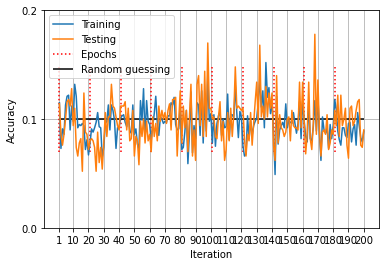

In [26]:
nn_plot_iter_acc(train_acc_dict["model_1"],
                 test_acc_dict["model_1"],
                 iteration_dict["model_1"],
                 mean_comparison = 0.1)

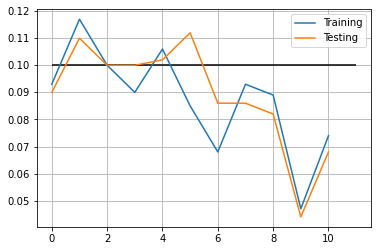

In [27]:
plt.plot(np.arange(len(mean_model_train_acc)), mean_model_train_acc, label = "Training")
plt.plot(np.arange(len(mean_model_test_acc)), mean_model_test_acc, label = "Testing")
plt.hlines(xmin = 0, xmax = len(mean_model_train_acc), y = 0.1, color = "black")
plt.legend()
plt.grid()
plt.show()